# Deep Neural Network Experiments: Attack vs All

Here we construct Deep Neural Networks using the fastai library. We then train the networks on the attack vs all datasets. These datasets are constructed by with a specific DDoS attack type and a basket of all other DDoS attack types as well as Benign samples. There are two collections of datasets:
 * Baseline: A dataset containing 70 features from the original 88 features used for baseline comparison.
 * Time-based: A dataset containing 26 features from the original 88 features, 23 of which are the time-based features used by Lashkari et al. in [this paper](https://www.researchgate.net/publication/314521450_Characterization_of_Tor_Traffic_using_Time_based_Features), 2 are time-based features ignored by Laskari et al. This dataset is used to evaluate the ability of a DNN to use time-based features to distingush between DDoS attacks.

The goal of these experiments is to understand how effective a Deep Neural Network is at discriminating between different attack types as well as to see how well time-based features can be used to classify DDoS attacks.

We start by importing relavent libraries, setting a seed for reproducibility, and by printing out the versions of the libraries we are using for reproducibility.

In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of, MixedPrecision, FP16TestCallback

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/downsampled/baseline/'
data_path_2: str = '../data/downsampled/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_ddos_200000.csv" , "LDAP_vs_ddos_200000.csv"    , "MSSQL_vs_ddos_200000.csv" , "NetBIOS_vs_ddos_200000.csv" ,
    "NTP_vs_ddos_200000.csv" , "Portmap_vs_ddos_200000.csv" , "SNMP_vs_ddos_200000.csv"  , "SSDP_vs_ddos_200000.csv"    ,
    "Syn_vs_ddos_200000.csv" , "TFTP_vs_ddos_200000.csv"    , "UDP_vs_ddos_200000.csv"   , "UDPLag_vs_ddos_200000.csv"  ,
]


# enumerate dataset types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    	yellowbrick:	1.3.post1
    


If any of the versions of the libraries listed above are different on your system, the experiments may not be reproducible. The experiments may not even run

# Preliminaries

Here we create functions/classes to load the data, run the experiments, visualize the data, and various helper functions.

In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[20::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    # if not, load data and cache it
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df


class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()

We use run_experiment to execute each experiment which returns a 7-tuple containing the results of the experiment. 

We then define a series of visualization functions that take that 7-tuple and plot various graph, characterizing the results of the experiment.

In [3]:

def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run binary classification using K-Nearest Neighbors
        returns the 7-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'
    if 'Protocol' in df.columns:
        categorical_features: list = ['Protocol']
    else:
        categorical_features: list = []
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    mds = tabular_learner(dls)
    classes : list = list(mds.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a K-NN classifier
    # using SciKitLearn and print the results 
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')
    report = classification_report(y_test, prediction)
    print(report)


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')


    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)

    return results


def visualize_learning_curve_train(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[3], results[4])
    visualizer.show()


def visualize_learning_curve_test(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[5], results[6])
    visualizer.show()


def visualize_confusion_matrix(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.show()


def visualize_roc(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_pr_curve(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(results[1], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_report(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(results[1], classes=results[2], title=results[0], support=True)
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_class_balance(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=results[0])
    visualizer.fit(results[4], results[6])
    visualizer.show()

A series of generators are composed to load and package the data for the experiments. Since the expressions used are all generators, the data is loaded only once it is used to run the experiment, afterwards it is eventually removed by the garbage collector.

In [4]:
# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files : list = list(map(baseline_path , datasets))
timebased_files: list = list(map(timebased_path, datasets))


# then we create a generator that will return the dataframes for each dataset
baseline_dfs : map = map(load_data   , baseline_files )
timebased_dfs: map = map(load_data   , timebased_files)
experiments  : zip = zip(baseline_dfs, timebased_dfs  , attacks)

Our experiments are defined and packaged in the generator

To run an experiment, we simply execute the expression: results = next(experiment)

To run a specific experiment, we execute the expression: results = do_experiment[experiment_number]

In [5]:
def experiment_runner():
    '''
        A generator that handles running the experiments
    '''
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results')
        baseline_results = run_experiment(baseline, f'{info}_vs_ddos_baseline')
        
        print('\nTime-based results')
        timebased_results = run_experiment(timebased, f'{info}_vs_ddos_timebased')
        
        num += 1
        yield (baseline_results, timebased_results, info, num)


def do_experiment(num: int) -> tuple:
    '''
        A function that runs the specific experiment specified
    '''
    index = num - 1
    baseline = load_data(baseline_files[index])
    timebased = load_data(timebased_files[index])
    info = attacks[index]

    print(f'Running experiment #{num}:\t{info}')

    print('Baseline results')
    baseline_results = run_experiment(baseline, f'{info}_vs_ddos_baseline')
    
    print('\nTime-based results')
    timebased_results = run_experiment(timebased, f'{info}_vs_ddos_timebased')

    return (baseline_results, timebased_results, info, num)


experiment = experiment_runner()

# Experiments

Our experiments are now conducted, the results are taken and are used to create a series of visualizations each representing various aspects of the experiments. 

The Baseline results are plotted followed by the Timebased results for each graph

the variable results holds the references to all the datasets being used by the current experiment, once the next experiment is executed, the results variabe is overwritten and the references to the previous datasets are removed. The previous datasets are then eventually removed from memory by the garbage collector.

## Experiment #1: DNS vs DDoS

In [6]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/DNS_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/DNS_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/DNS_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/DNS_vs_ddos_200000.csv.pickle

Running experiment #1:	DNS
Baseline results
	Accuracy: 0.8829691484574229

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     19924
           1       0.87      0.90      0.89     20074

    accuracy                           0.88     39998
   macro avg       0.88      0.88      0.88     39998
weighted avg       0.88      0.88      0.88     39998


Time-based results
	Accuracy: 0.8839941997099855

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     19924
           1       0.89      0.88      0.88     20074

    accuracy                           0.88     39998
   macro avg       0.88      0.88      0.88

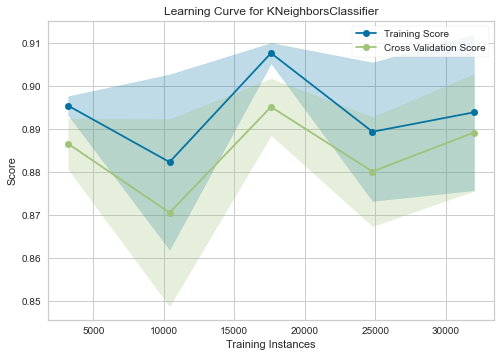

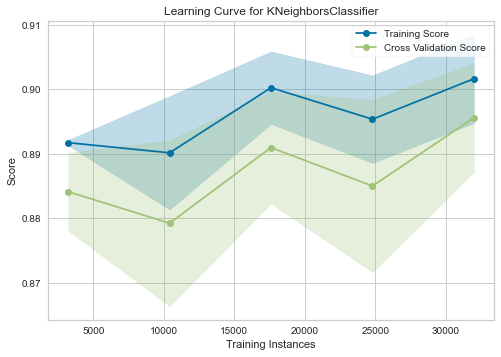

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


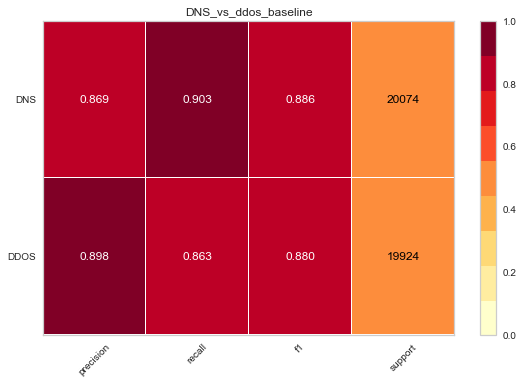

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


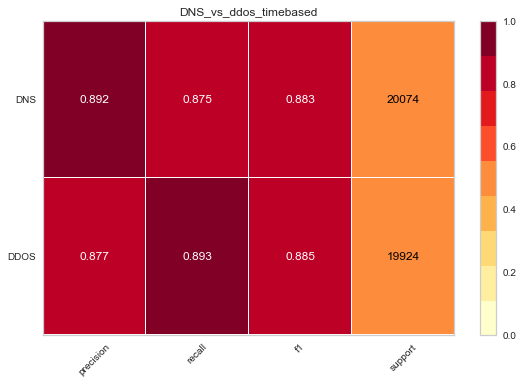

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


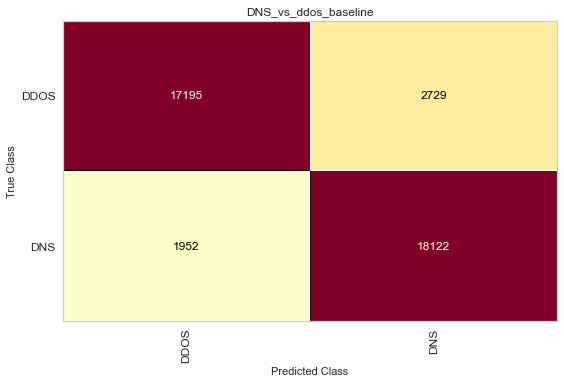

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


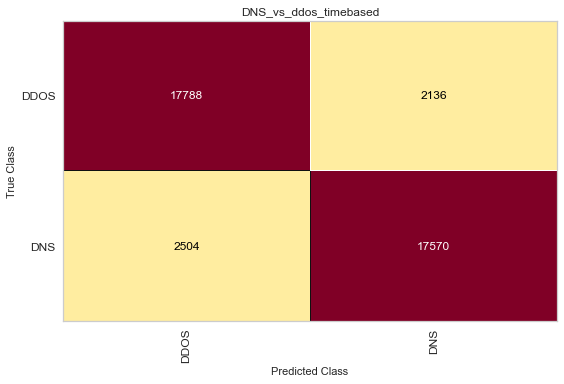

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


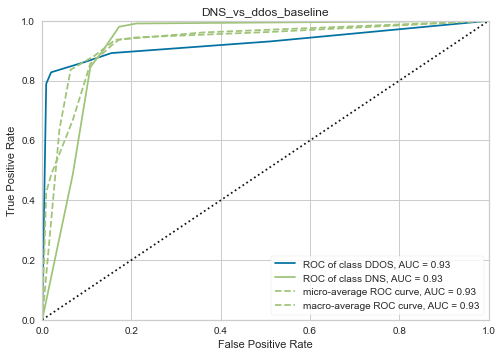

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


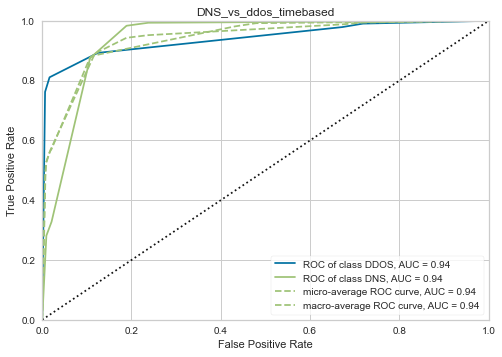

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


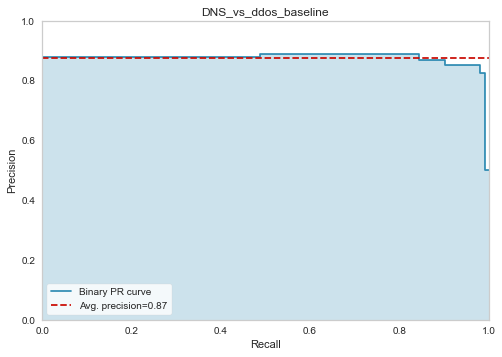

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


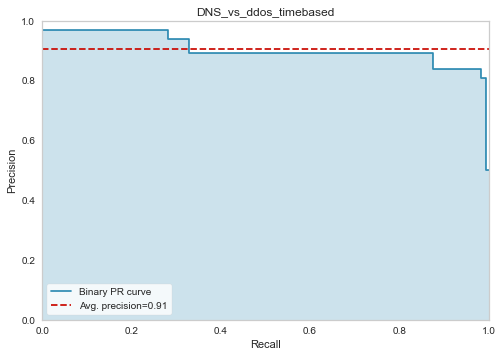

In [7]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #2: LDAP vs DDoS

In [8]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/LDAP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/LDAP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/LDAP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/LDAP_vs_ddos_200000.csv.pickle

Running experiment #2:	LDAP
Baseline results
	Accuracy: 0.9174958747937397

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     19924
           1       0.88      0.97      0.92     20074

    accuracy                           0.92     39998
   macro avg       0.92      0.92      0.92     39998
weighted avg       0.92      0.92      0.92     39998


Time-based results
	Accuracy: 0.9228961448072404

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     19924
           1       0.87      0.99      0.93     20074

    accuracy                           0.92     39998
   macro avg       0.93      0.92     

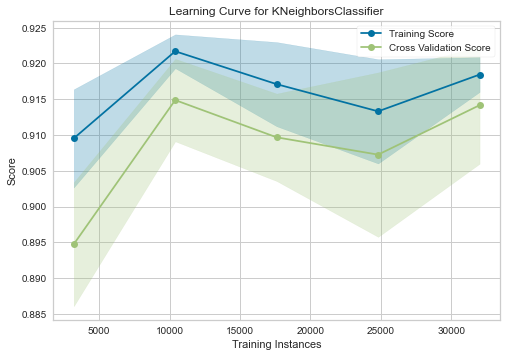

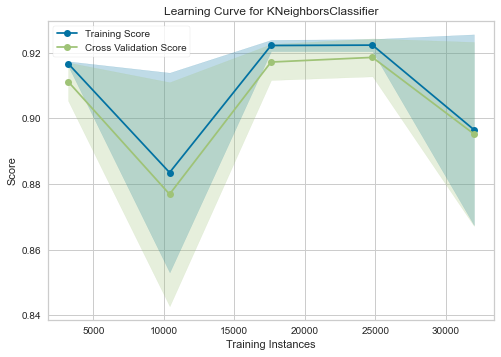

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


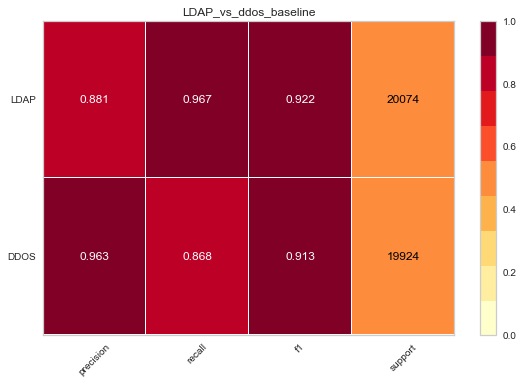

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


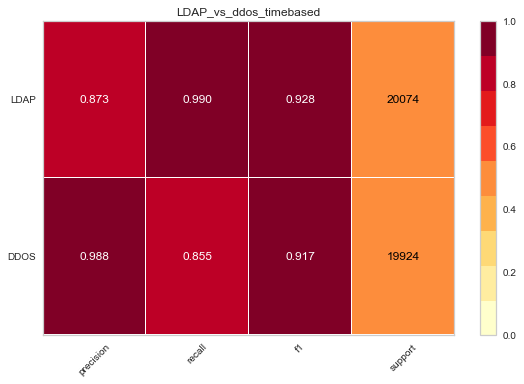

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


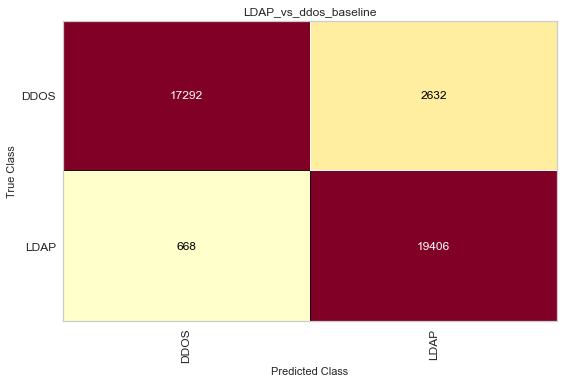

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


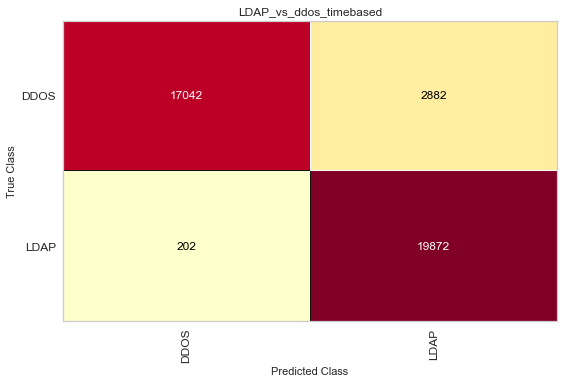

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


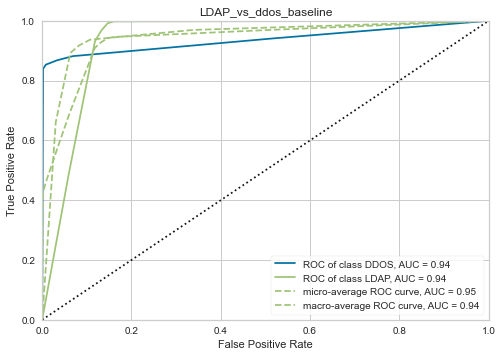

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


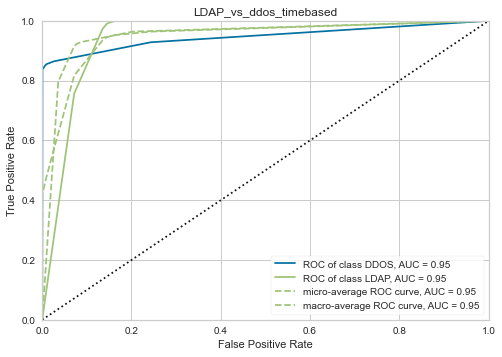

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


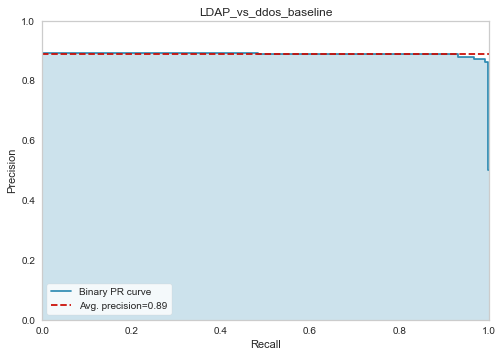

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


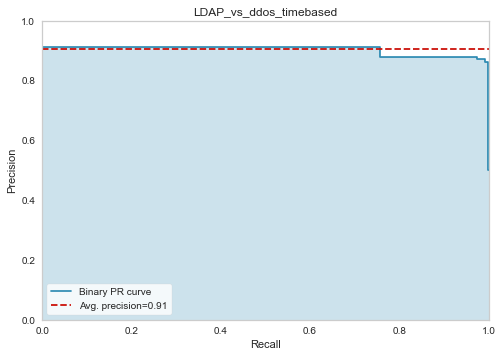

In [9]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #3: MSSQL vs DDoS

In [10]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/MSSQL_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/MSSQL_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/MSSQL_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/MSSQL_vs_ddos_200000.csv.pickle

Running experiment #3:	MSSQL
Baseline results
	Accuracy: 0.9766738336916846

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     19924
           1       0.98      0.97      0.98     20074

    accuracy                           0.98     39998
   macro avg       0.98      0.98      0.98     39998
weighted avg       0.98      0.98      0.98     39998


Time-based results
	Accuracy: 0.9735486774338717

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     19924
           1       0.98      0.96      0.97     20074

    accuracy                           0.97     39998
   macro avg       0.97      0.97

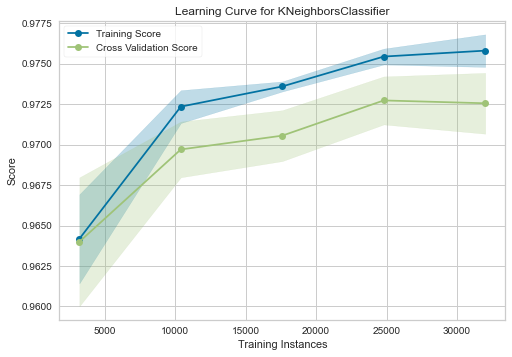

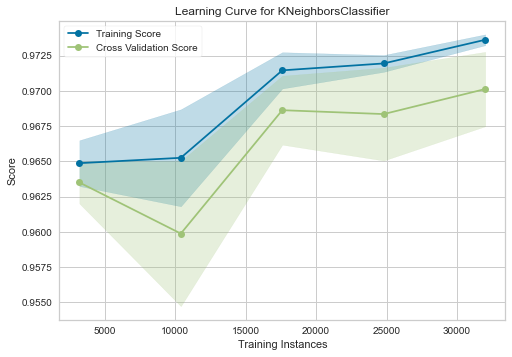

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


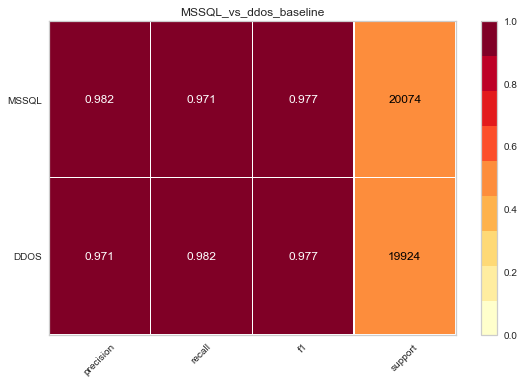

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


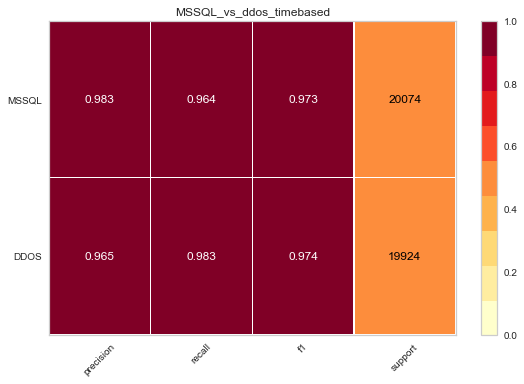

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


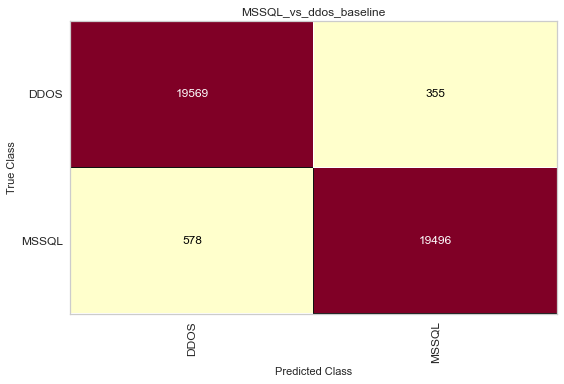

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


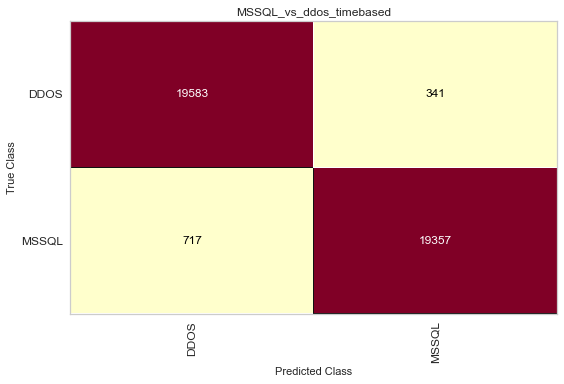

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


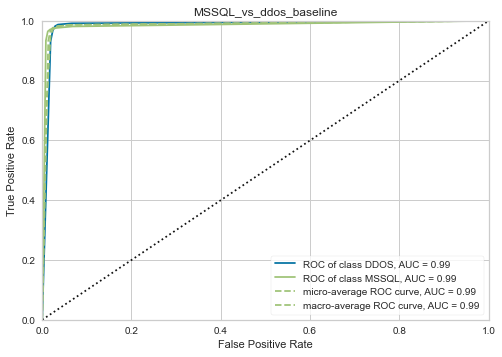

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


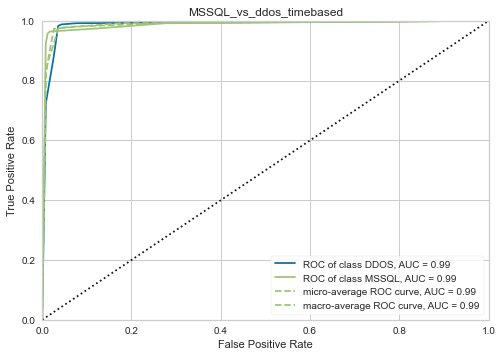

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


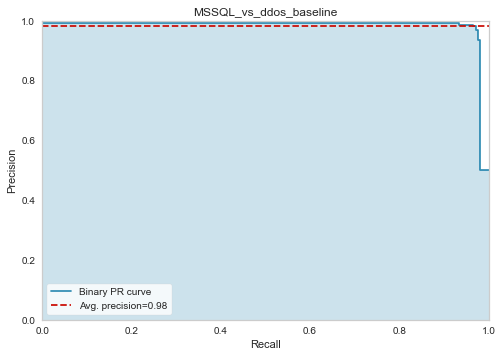

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


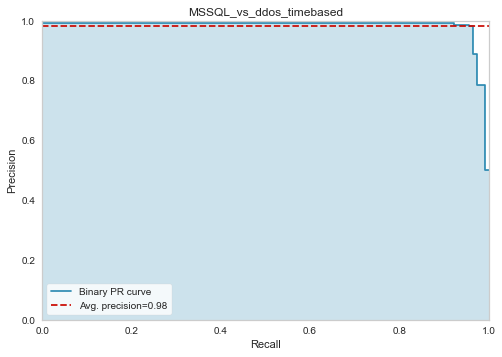

In [11]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #4: NetBIOS vs DDoS

In [12]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/NetBIOS_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/NetBIOS_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/NetBIOS_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/NetBIOS_vs_ddos_200000.csv.pickle

Running experiment #4:	NetBIOS
Baseline results
	Accuracy: 0.9471473573678684

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19924
           1       0.91      0.99      0.95     20074

    accuracy                           0.95     39998
   macro avg       0.95      0.95      0.95     39998
weighted avg       0.95      0.95      0.95     39998


Time-based results
	Accuracy: 0.9488474423721186

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     19924
           1       0.91      0.99      0.95     20074

    accuracy                           0.95     39998
   macro avg       0.95

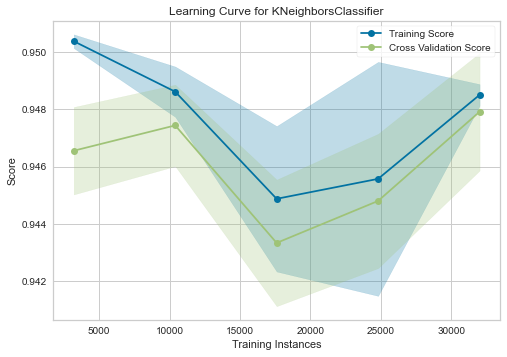

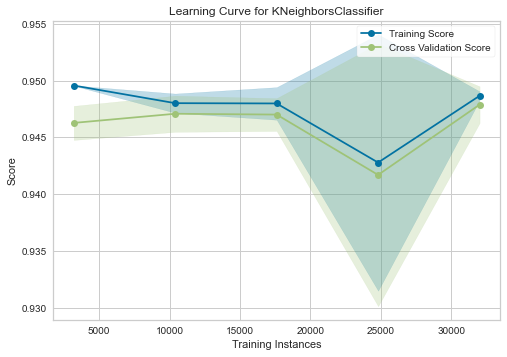

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


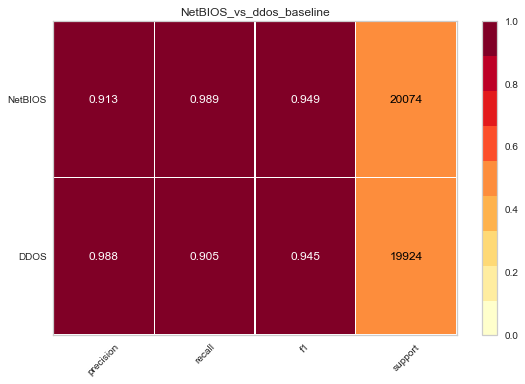

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


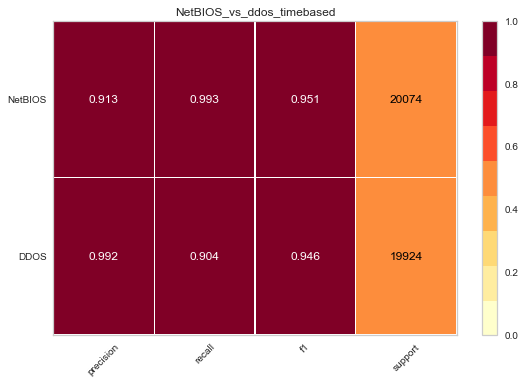

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


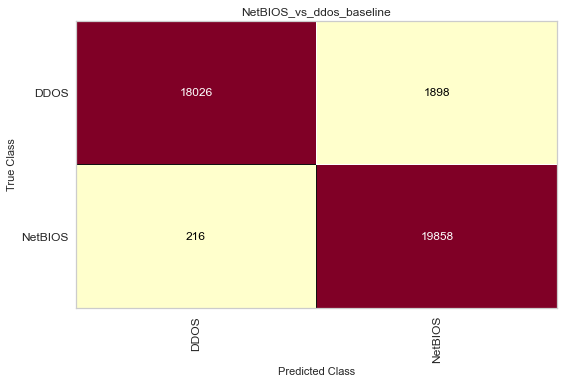

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


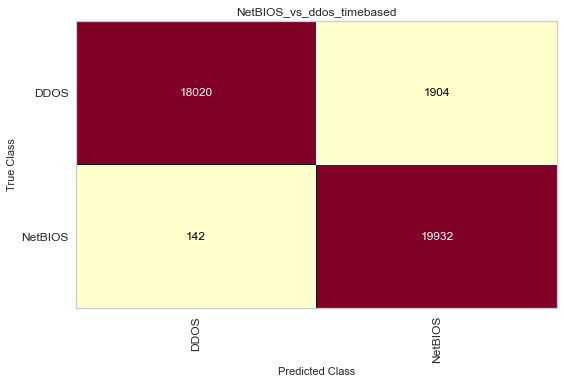

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


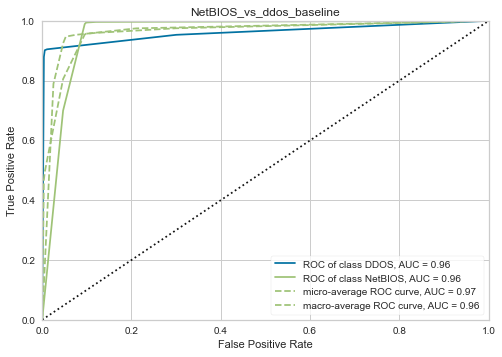

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


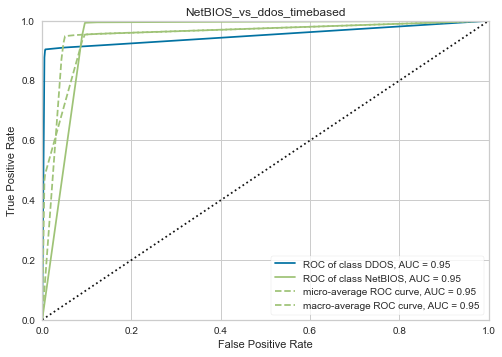

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


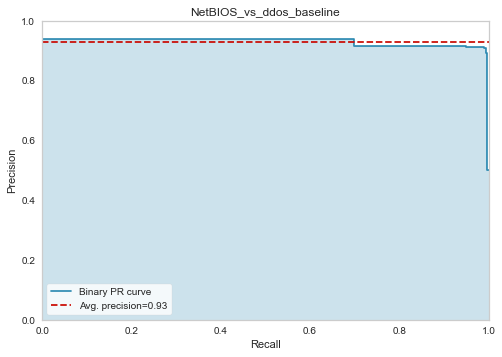

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


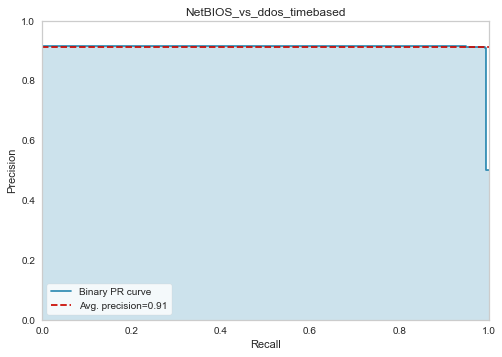

In [13]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #5: NTP vs DDoS

In [16]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/NTP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/NTP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/NTP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/NTP_vs_ddos_200000.csv.pickle

Running experiment #5:	NTP
Baseline results
	Accuracy: 0.9989499474973749

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19924
           1       1.00      1.00      1.00     20074

    accuracy                           1.00     39998
   macro avg       1.00      1.00      1.00     39998
weighted avg       1.00      1.00      1.00     39998


Time-based results
	Accuracy: 0.9960498024901245

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19924
           1       0.99      1.00      1.00     20074

    accuracy                           1.00     39998
   macro avg       1.00      1.00      1.00

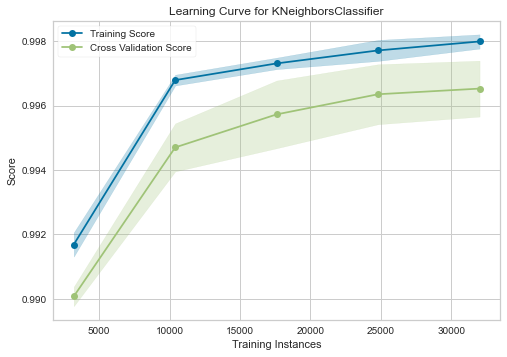

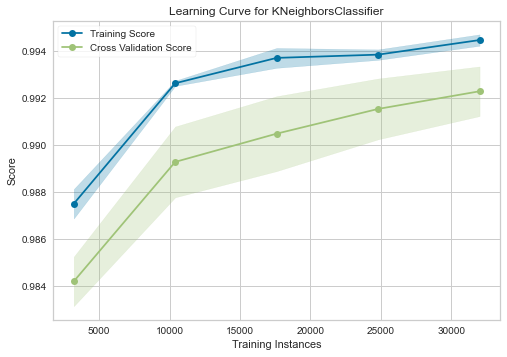

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


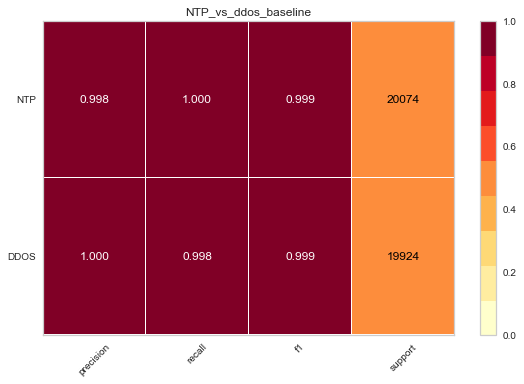

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


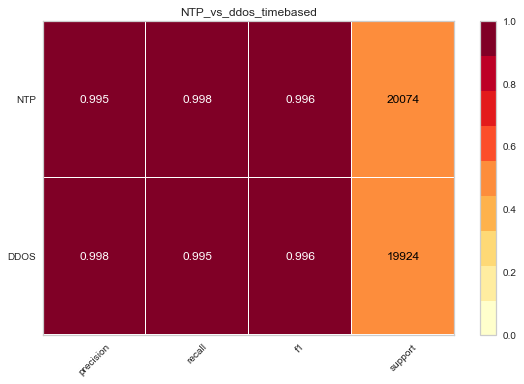

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


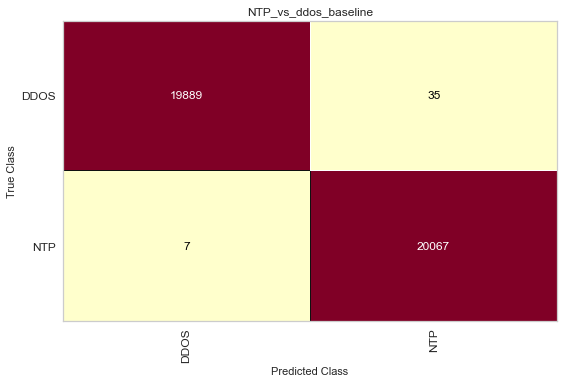

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


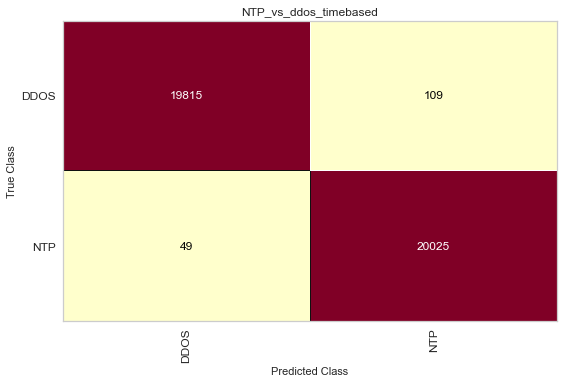

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


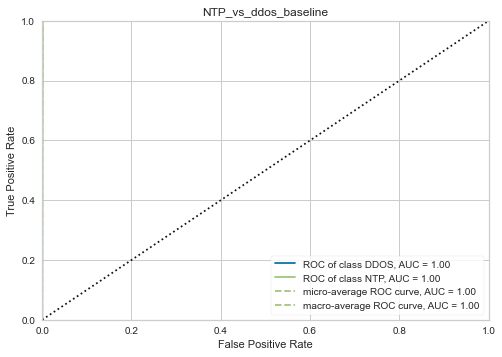

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


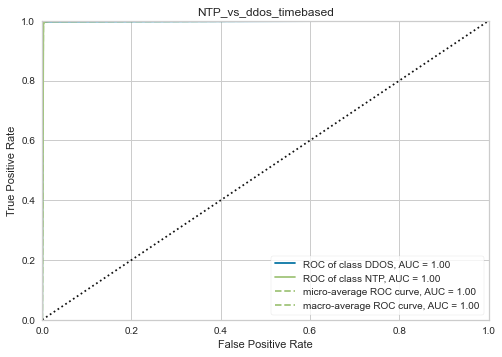

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


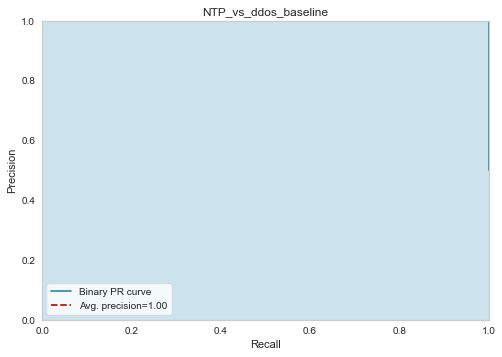

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


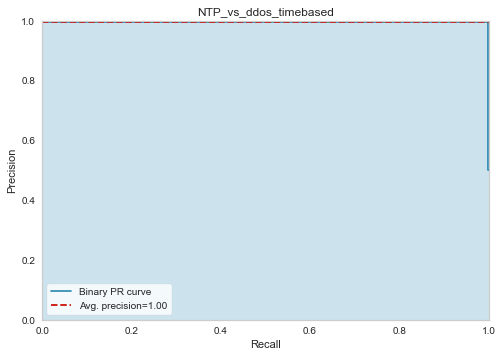

In [17]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #6: Portmap vs DDoS

In [18]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/Portmap_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/Portmap_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/Portmap_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/Portmap_vs_ddos_200000.csv.pickle

Running experiment #6:	Portmap
Baseline results
	Accuracy: 0.9583229161458073

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     19924
           1       0.93      0.99      0.96     20074

    accuracy                           0.96     39998
   macro avg       0.96      0.96      0.96     39998
weighted avg       0.96      0.96      0.96     39998


Time-based results
	Accuracy: 0.9507975398769939

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     19924
           1       0.91      1.00      0.95     20074

    accuracy                           0.95     39998
   macro avg       0.95

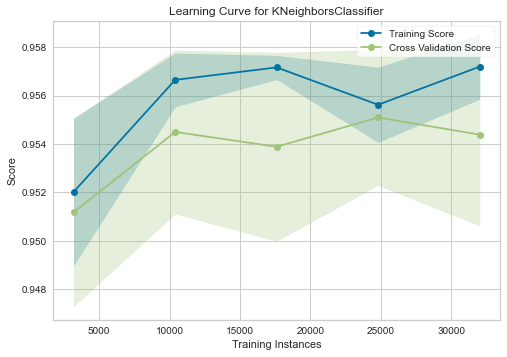

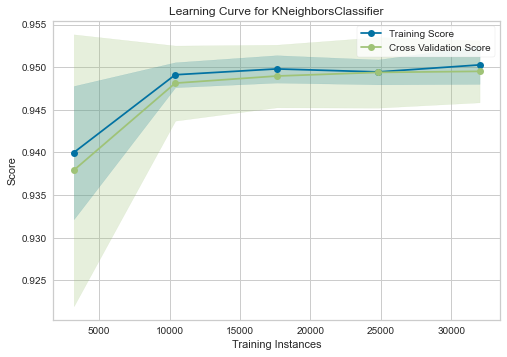

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


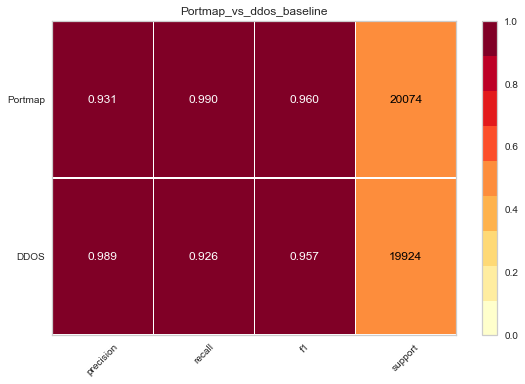

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


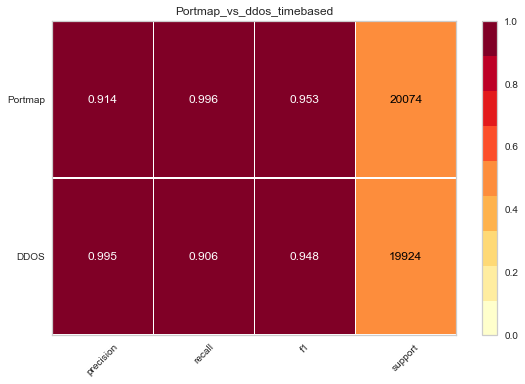

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


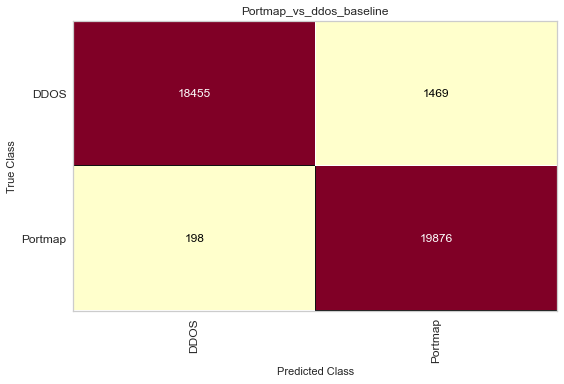

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


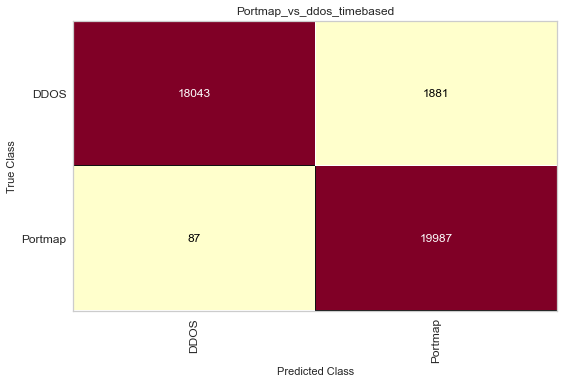

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


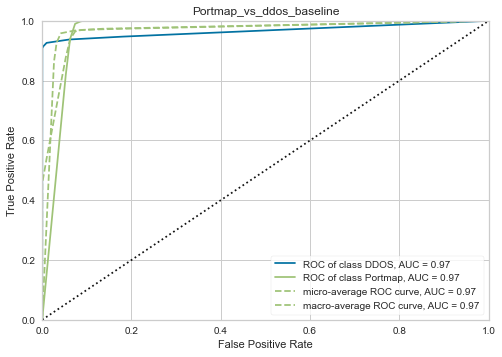

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


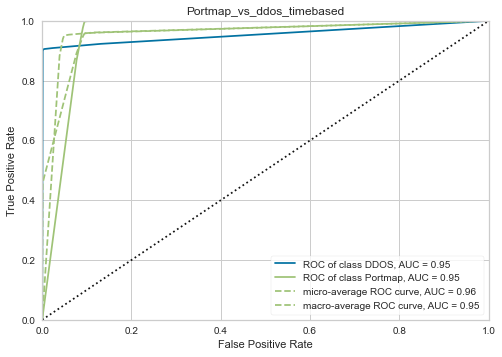

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


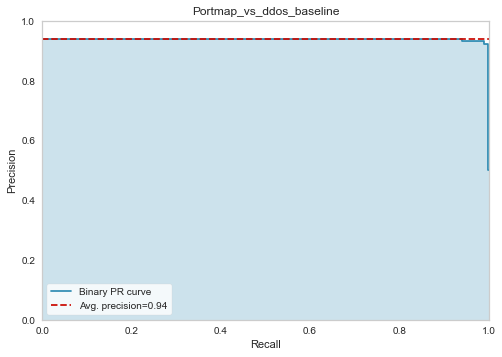

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


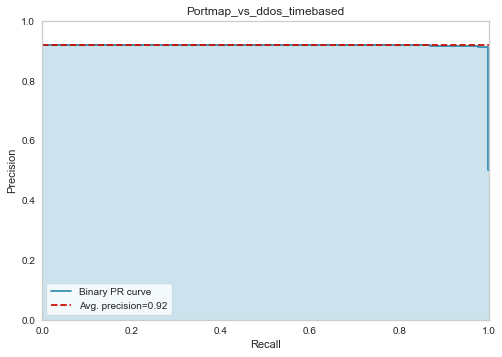

In [19]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #7: SNMP vs DDoS

In [20]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/SNMP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/SNMP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/SNMP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/SNMP_vs_ddos_200000.csv.pickle

Running experiment #7:	SNMP
Baseline results
	Accuracy: 0.8962198109905495

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19924
           1       0.93      0.86      0.89     20074

    accuracy                           0.90     39998
   macro avg       0.90      0.90      0.90     39998
weighted avg       0.90      0.90      0.90     39998


Time-based results
	Accuracy: 0.8946697334866743

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     19924
           1       0.86      0.95      0.90     20074

    accuracy                           0.89     39998
   macro avg       0.90      0.89     

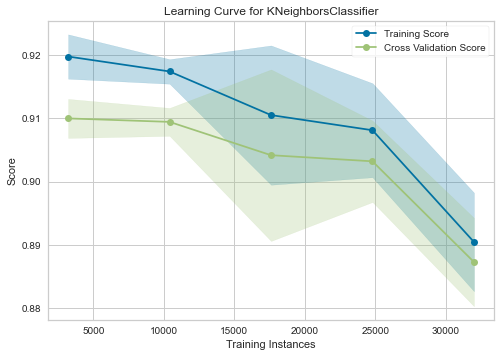

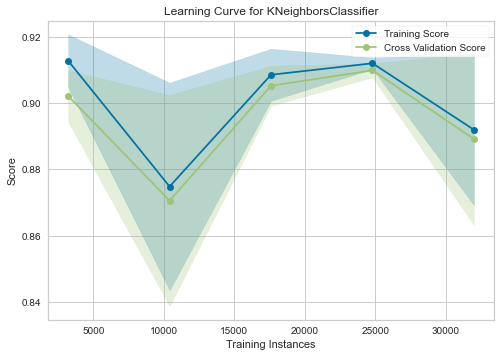

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


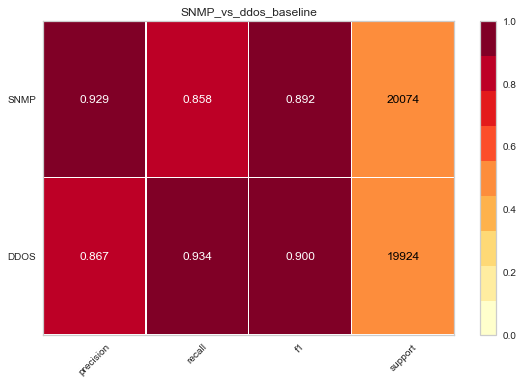

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


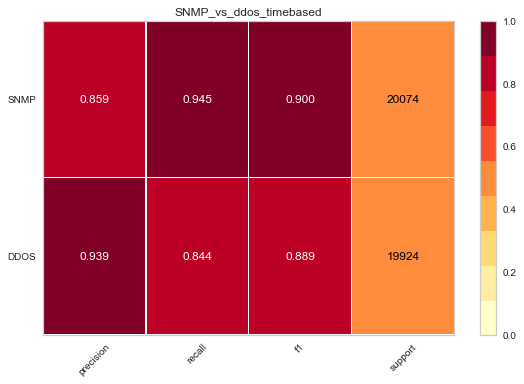

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


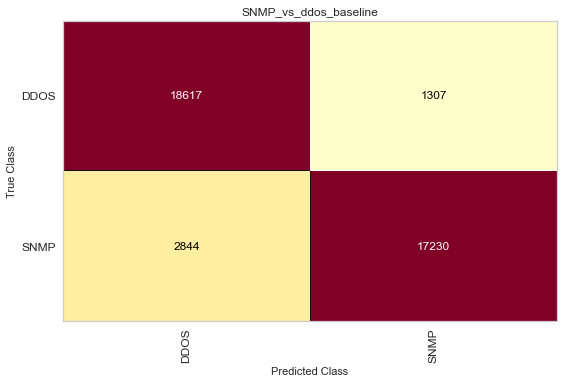

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


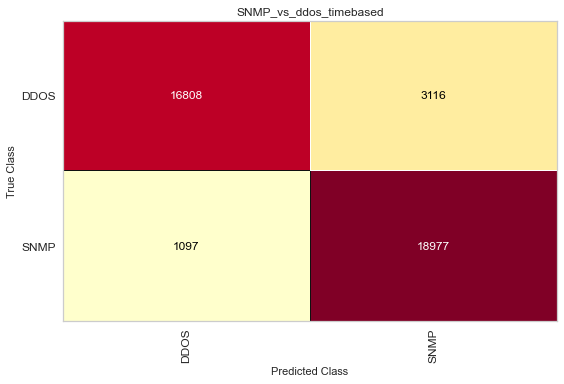

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


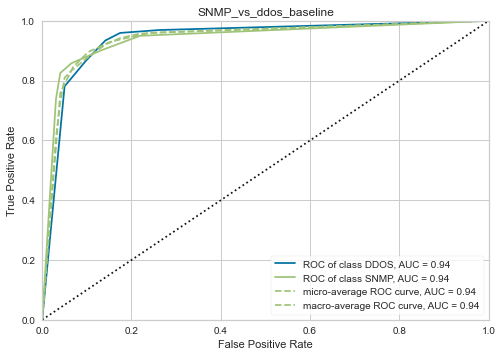

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


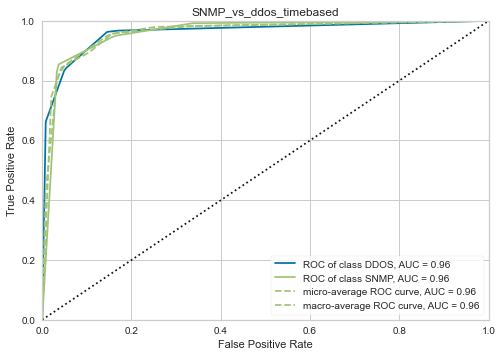

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


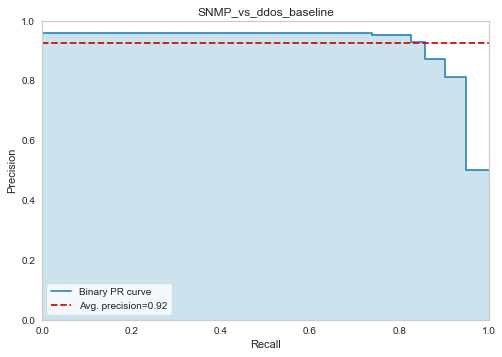

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


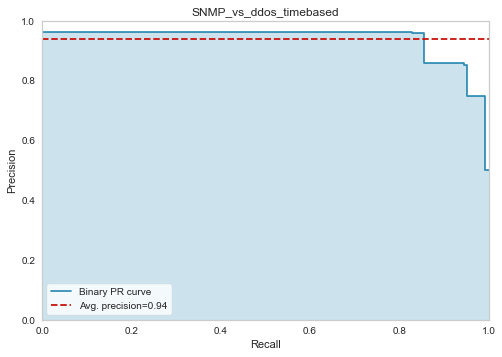

In [21]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #8: SSDP vs DDoS

In [22]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/SSDP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/SSDP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/SSDP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/SSDP_vs_ddos_200000.csv.pickle

Running experiment #8:	SSDP
Baseline results
	Accuracy: 0.931921596079804

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     19924
           1       0.90      0.97      0.93     20074

    accuracy                           0.93     39998
   macro avg       0.94      0.93      0.93     39998
weighted avg       0.94      0.93      0.93     39998


Time-based results
	Accuracy: 0.9270713535676783

              precision    recall  f1-score   support

           0       0.97      0.89      0.92     19924
           1       0.89      0.97      0.93     20074

    accuracy                           0.93     39998
   macro avg       0.93      0.93      

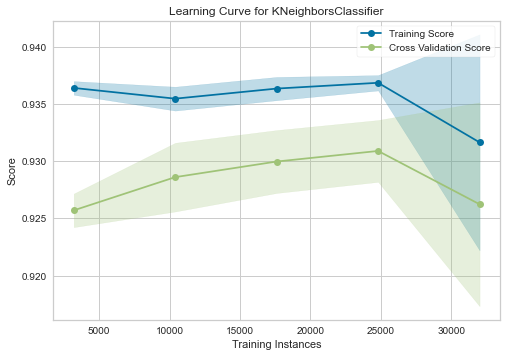

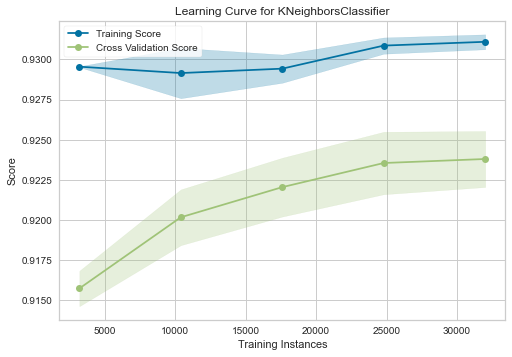

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


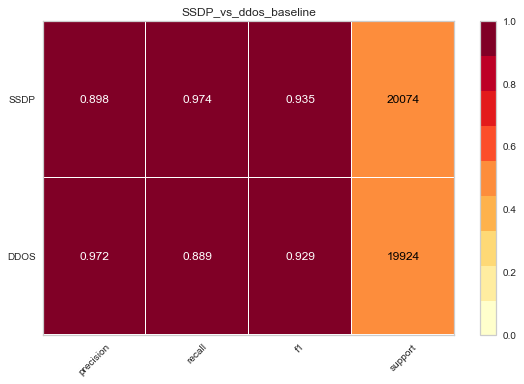

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


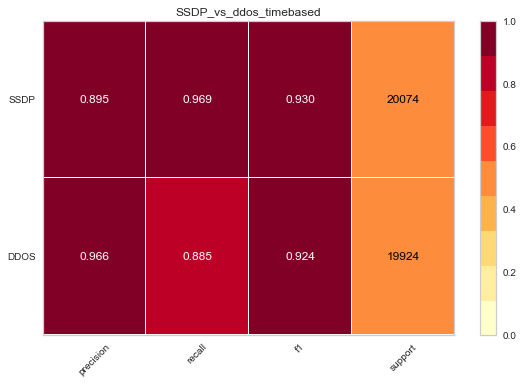

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


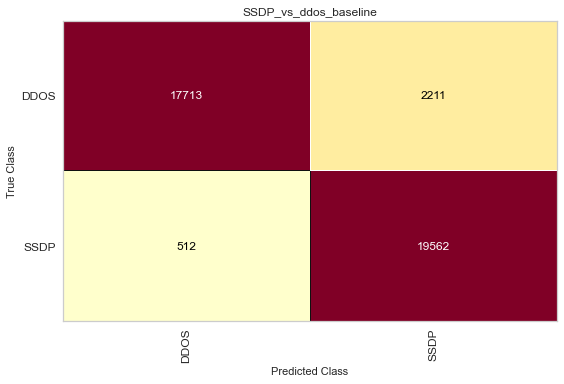

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


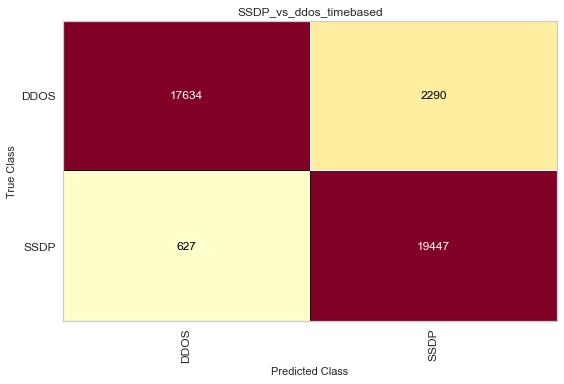

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


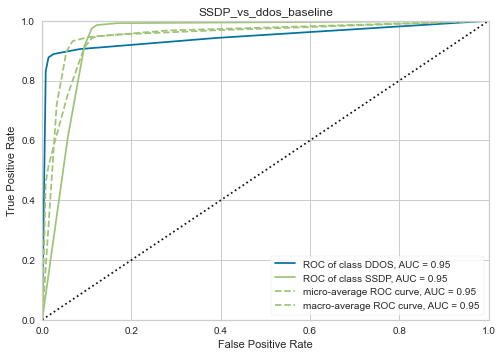

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


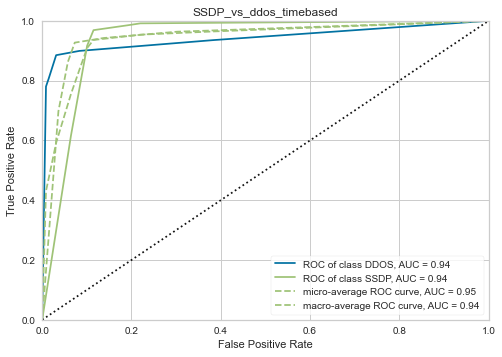

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


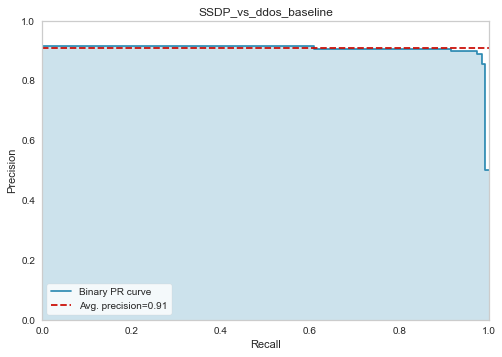

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


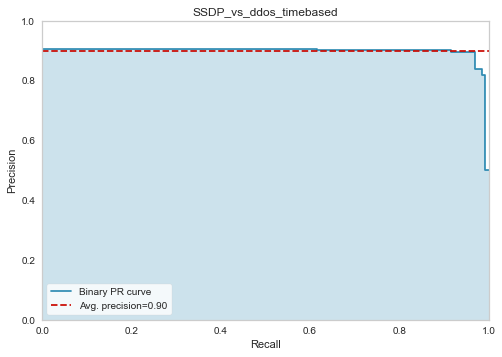

In [23]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #9: Syn vs DDoS

In [24]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/Syn_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/Syn_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/Syn_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/Syn_vs_ddos_200000.csv.pickle

Running experiment #9:	Syn
Baseline results
	Accuracy: 0.9662733136656833

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19924
           1       0.94      1.00      0.97     20074

    accuracy                           0.97     39998
   macro avg       0.97      0.97      0.97     39998
weighted avg       0.97      0.97      0.97     39998


Time-based results
	Accuracy: 0.9613980699034952

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     19924
           1       0.94      0.99      0.96     20074

    accuracy                           0.96     39998
   macro avg       0.96      0.96      0.96

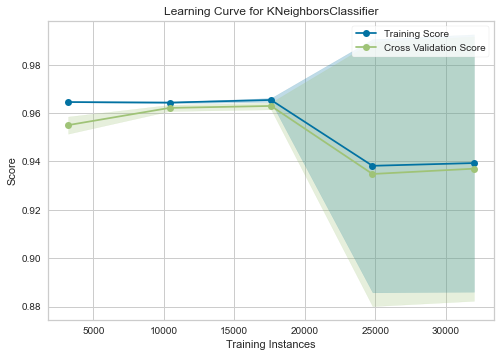

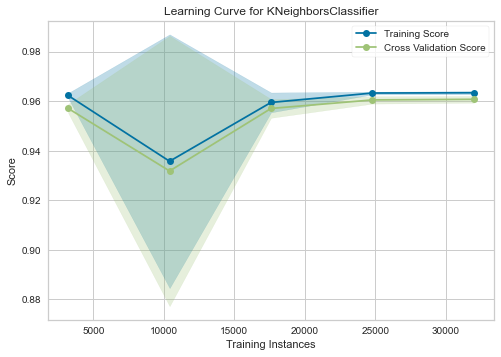

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


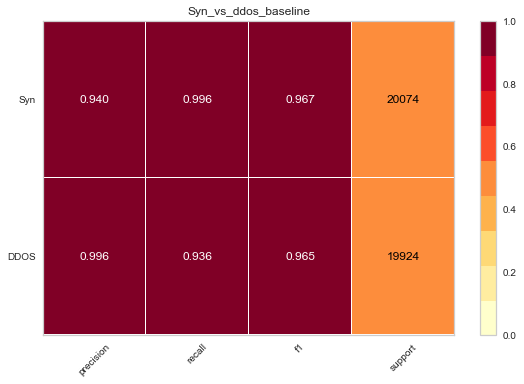

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


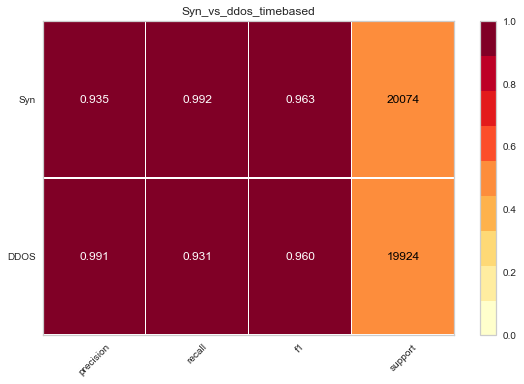

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


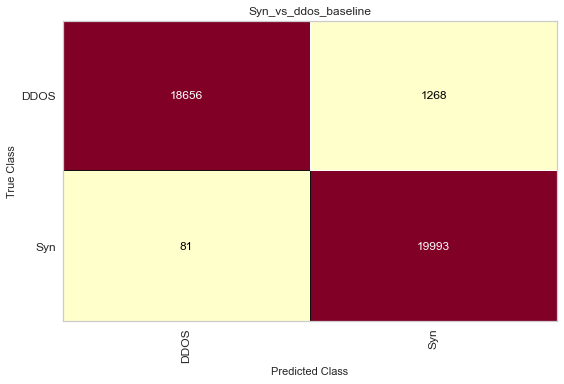

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


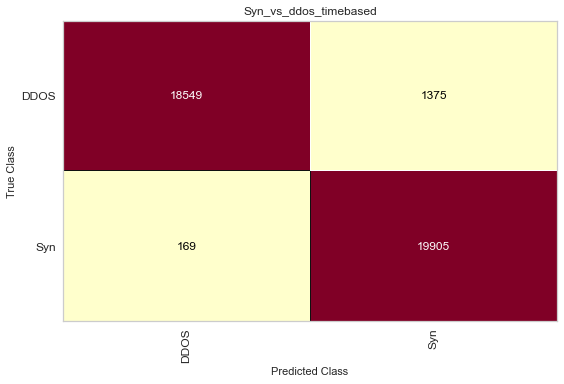

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


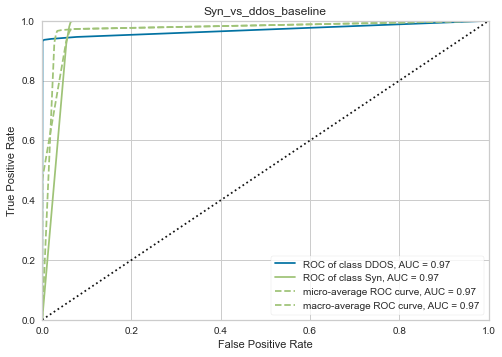

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


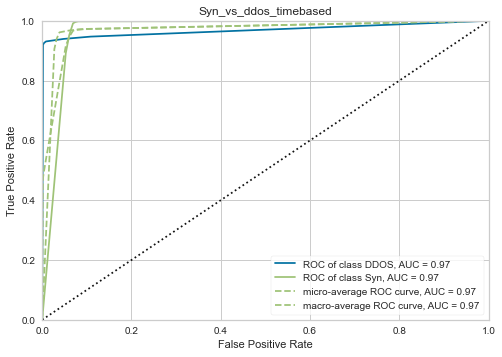

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


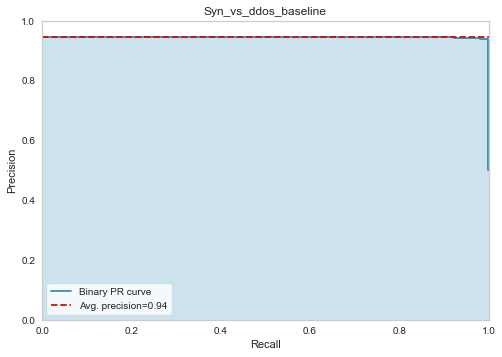

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


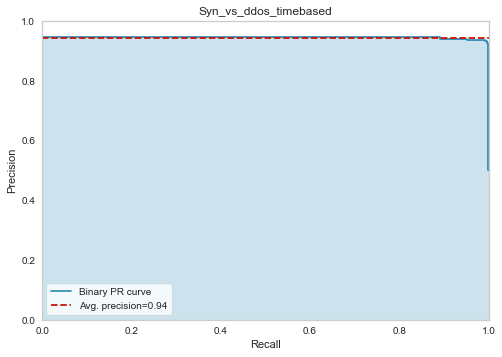

In [25]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #10: TFTP vs DDoS

In [26]:
results = next(experiment)

Loading Dataset: ../data/downsampled/baseline/TFTP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/TFTP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/TFTP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/TFTP_vs_ddos_200000.csv.pickle

Running experiment #10:	TFTP
Baseline results
	Accuracy: 0.9943497174858743

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19924
           1       1.00      0.99      0.99     20074

    accuracy                           0.99     39998
   macro avg       0.99      0.99      0.99     39998
weighted avg       0.99      0.99      0.99     39998


Time-based results
	Accuracy: 0.9938496924846242

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19924
           1       1.00      0.99      0.99     20074

    accuracy                           0.99     39998
   macro avg       0.99      0.99    

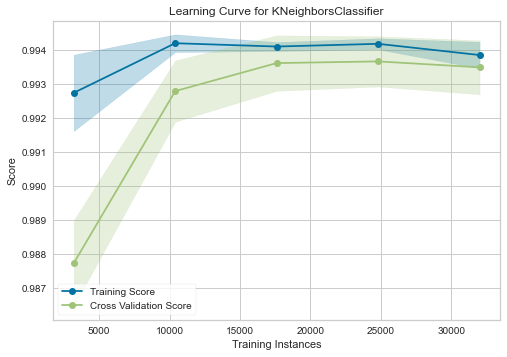

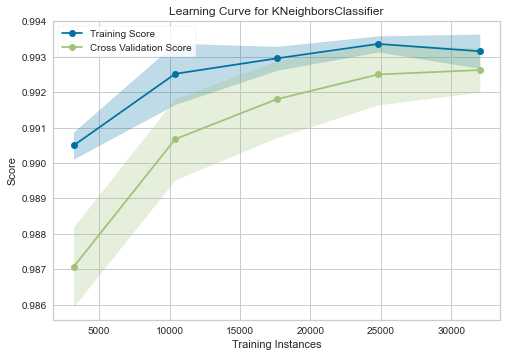

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


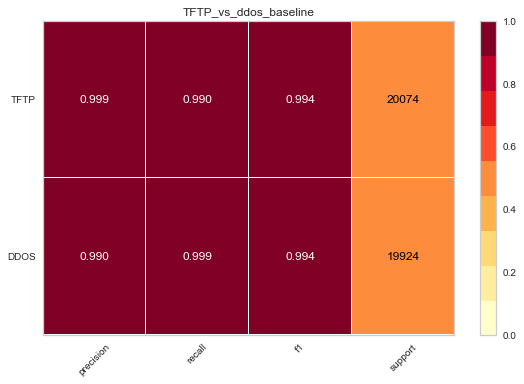

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


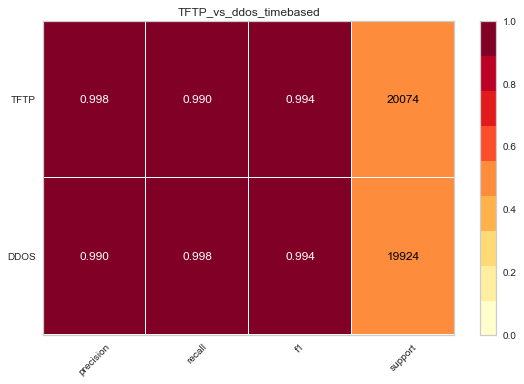

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


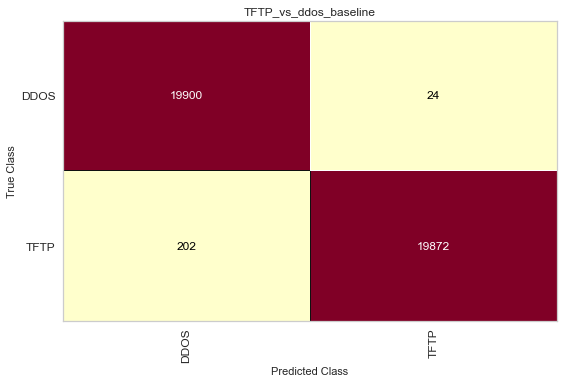

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


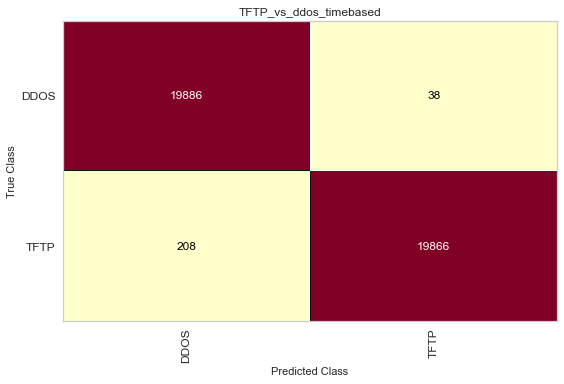

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


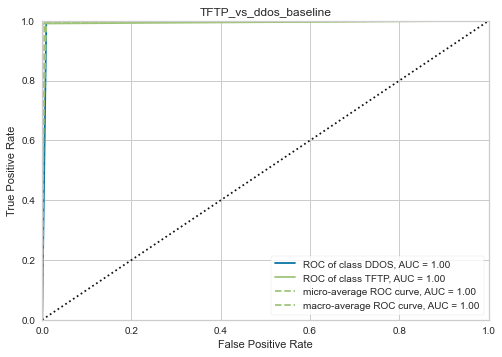

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


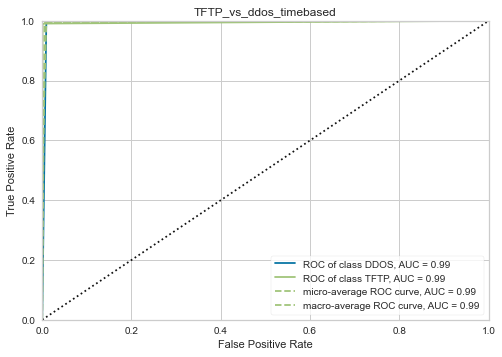

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


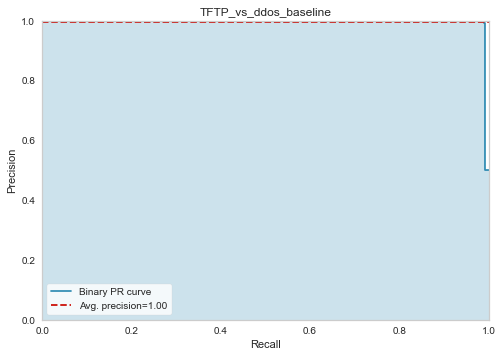

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


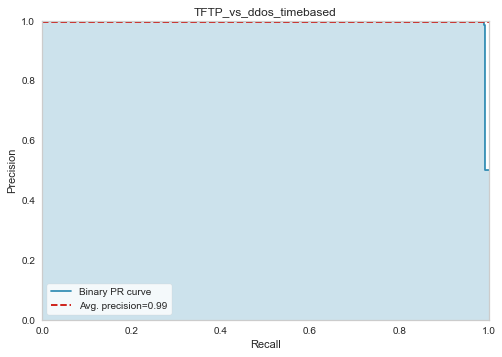

In [27]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #11: UDP vs DDoS

In [29]:
results = next(experiment)
# results = do_experiment(12)

Loading Dataset: ../data/downsampled/baseline/UDP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/UDP_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/UDP_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/UDP_vs_ddos_200000.csv.pickle

Running experiment #11:	UDP
Baseline results
	Accuracy: 0.9149707485374269

              precision    recall  f1-score   support

           0       0.93      0.90      0.91     19924
           1       0.90      0.93      0.92     20074

    accuracy                           0.91     39998
   macro avg       0.92      0.91      0.91     39998
weighted avg       0.92      0.91      0.91     39998


Time-based results
	Accuracy: 0.9327466373318666

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     19924
           1       0.90      0.98      0.94     20074

    accuracy                           0.93     39998
   macro avg       0.94      0.93      0.9

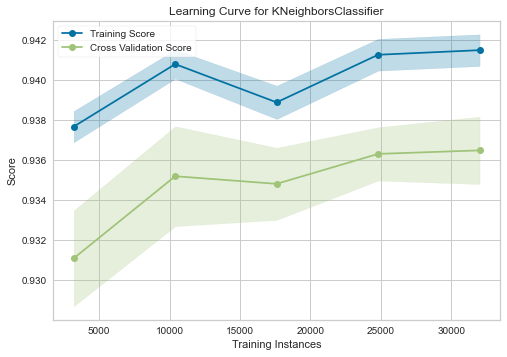

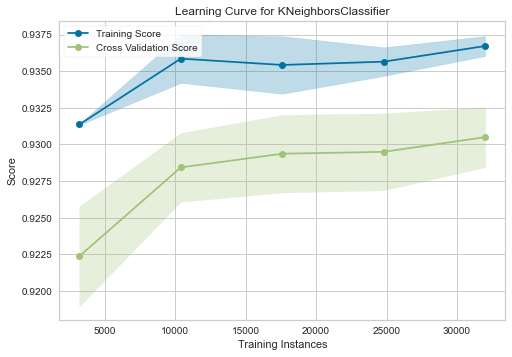

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


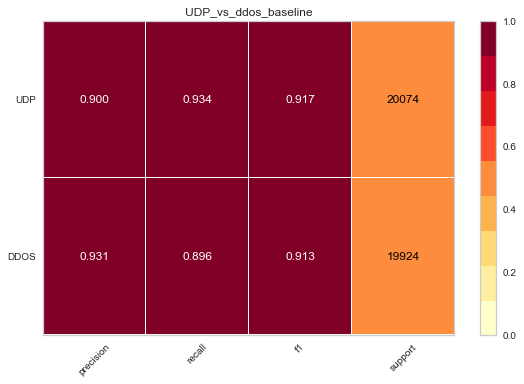

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


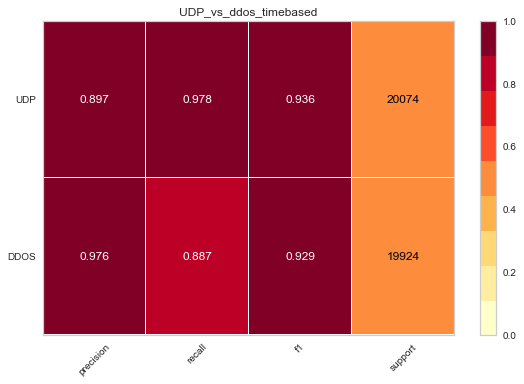

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


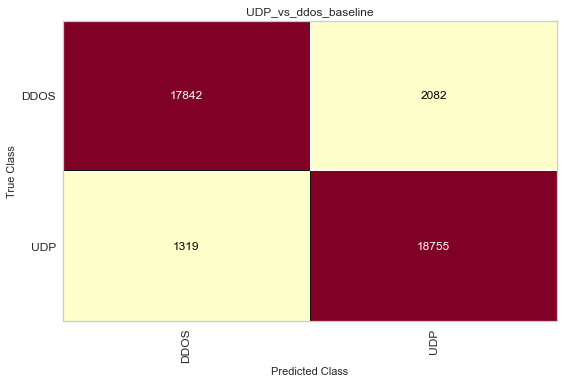

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


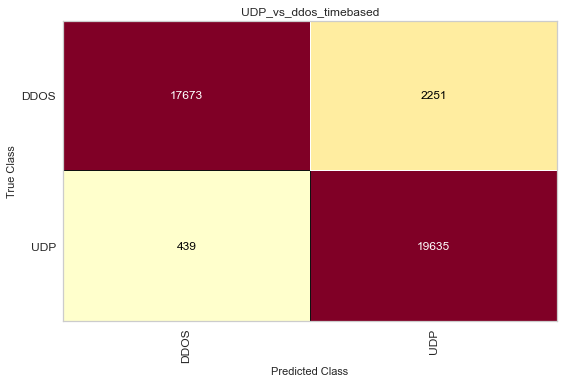

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


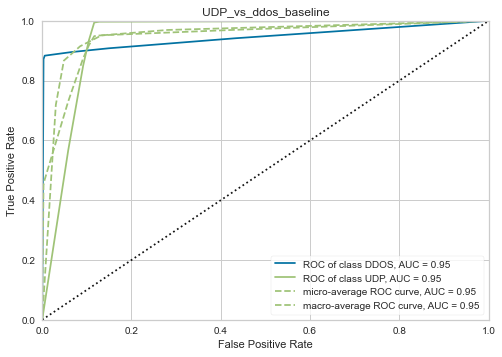

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


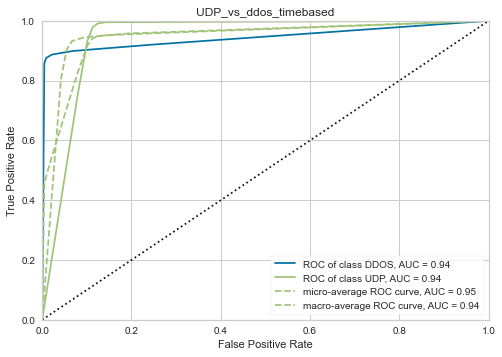

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


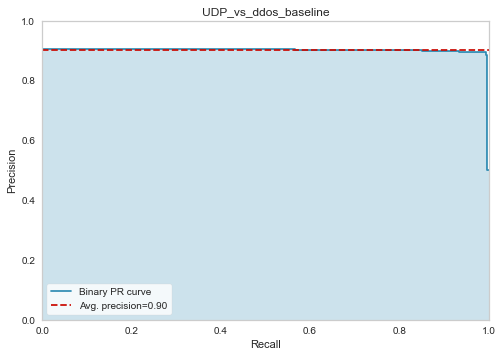

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


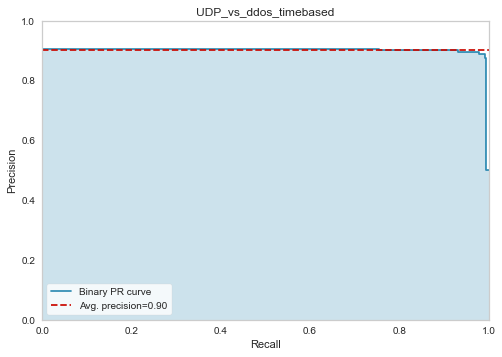

In [30]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #12: UDP-lag vs DDoS

In [7]:
# results = next(experiment)
results = do_experiment(12)

Loading Dataset: ../data/downsampled/baseline/UDPLag_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/baseline/UDPLag_vs_ddos_200000.csv.pickle

Loading Dataset: ../data/downsampled/timebased/UDPLag_vs_ddos_200000.csv
	To Dataset Cache: ../data/cache/timebased/UDPLag_vs_ddos_200000.csv.pickle

Running experiment #12:	UDPLag
Baseline results
	Accuracy: 0.9020701035051752

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     19924
           1       0.91      0.90      0.90     20074

    accuracy                           0.90     39998
   macro avg       0.90      0.90      0.90     39998
weighted avg       0.90      0.90      0.90     39998


Time-based results
	Accuracy: 0.9007200360018001

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     19924
           1       0.88      0.92      0.90     20074

    accuracy                           0.90     39998
   macro avg       0.90    

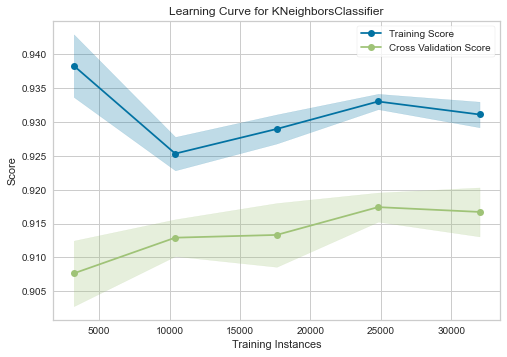

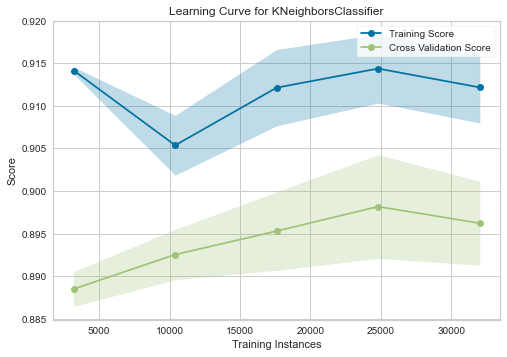

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


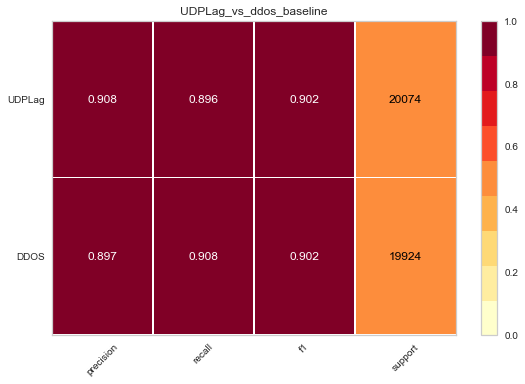

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


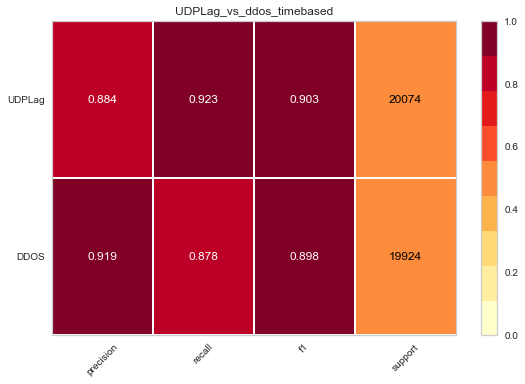

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


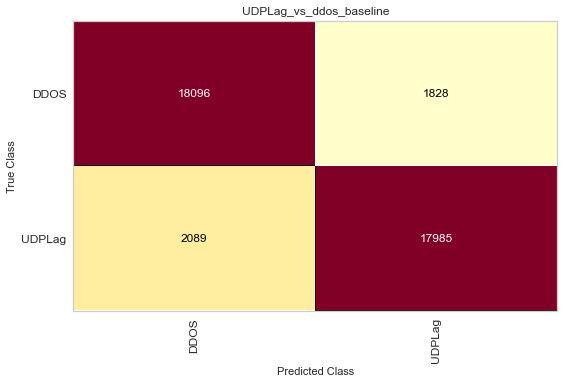

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


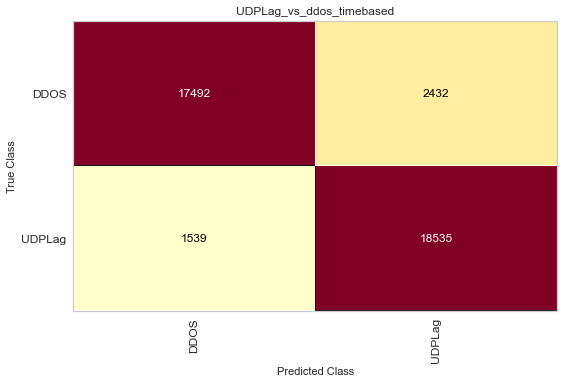

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


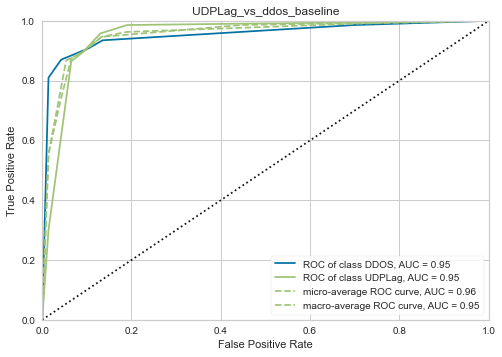

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


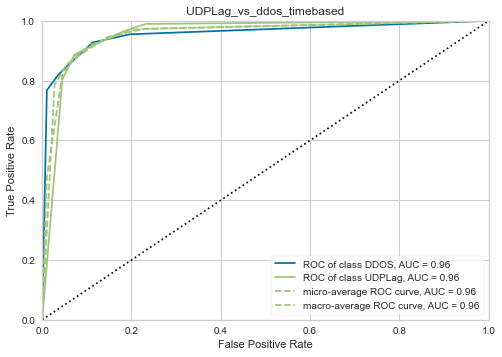

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


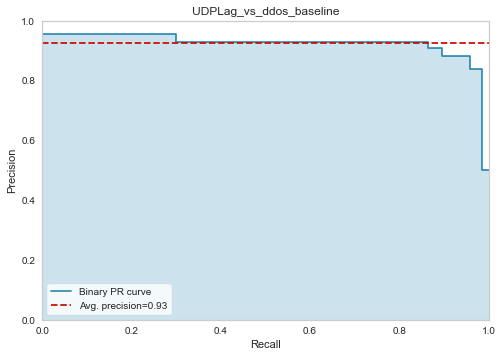

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


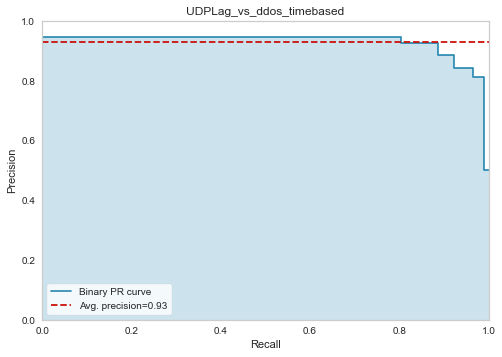

In [8]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])